# Support Vector Machine

## Performance Tuning

Hyperparameters
- C

Others
- Kernelization mapping (Linear, Polynomial, Gaussian, etc.)

In [112]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn graphviz


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [113]:
# import stuff
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

## Model from Scratch

In [114]:
# https://adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-linear-svm/
# https://dev.to/harsimranjit_singh_0133dc/support-vector-machines-from-hard-margin-to-soft-margin-1bj1

# Soft Margin SVM
class SVM_Linear_Scratch:
    def __init__(self, C=1, batch_size=100, learning_rate=0.001, iterations=1000):
        # C = error term
        self.C = C
        self.batch_size = batch_size
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.w = None
        self.b = None

    def decision_function(self, X):
        return np.dot(X, self.w) + self.b # w.x + b

    def hingeloss(self, w, b, x, y):
        # Regularizer term
        reg = 0.5 * (w * w)

        for i in range(x.shape[0]):
            # Optimization term
            opt_term = y[i] * ((np.dot(w, x[i])) + b)
            loss = reg + self.C * max(0, 1 - opt_term)

        return loss[0]

    def fit(self, X, Y):
        # initialize
        n_samples = X.shape[0]
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        self.b = 0
        losses = []

        # convert y to signed value (-1, +1)
        Y = np.where(Y <= 0, -1, 1)

        # gradient descent optimization start
        for i in range(self.iterations):
            l = self.hingeloss(self.w, self.b, X, Y)
            losses.append(l)

            # iterate through samples with batch_size as interval
            for batch_start in range(0, n_samples, self.batch_size):
                gradw = 0
                gradb = 0
                for x in range(batch_start, batch_start + self.batch_size):
                    if x >= n_samples:
                        break
                     # correct classification
                    if Y[x] * self.decision_function(X[x]) >= 1:
                        gradw += 0 # w = w - α*w
                        gradb += 0  # b = b
                    # misclassification
                    else:
                        gradw += self.C * Y[x] * X[x]  # w = w - α*(w - C*yi*xi)
                        gradb += self.C * Y[x] # b = b - α*(C*yi)

                # Updating weights and bias
                self.w += self.learning_rate * gradw
                self.b += self.learning_rate * gradb

        return self.w, self.b, losses

    def predict(self, X):
        prediction = self.decision_function(X)
        label_signs = np.sign(prediction)
        result = np.where(label_signs <= -1, 0, 1)
        return result

In [115]:
# https://adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-kernel-svm/

class SVM_Non_Linear_Scratch:
    def __init__(self, kernel='poly', C=1, degree=2, const=1, sigma=0.1, iterations=1000, learning_rate= 0.001):
        self.X = None
        self.y = None
        self.alpha = None
        self.ones = None
        self.b = 0
        self.C = C
        self.iterations = iterations
        self.learning_rate = learning_rate

        if kernel == 'poly':
            self.kernel = self.polynomial_kernel
            self.degree = degree
            self.const = const
        elif kernel == 'rbf':
            self.kernel =  self.gaussian_kernel
            self.sigma = sigma

    def polynomial_kernel(self, X, Z):
        # K(X, Z) = (c + X.Z)^degree
        return (self.const + X.dot(Z.T))**self.degree

    def gaussian_kernel(self, X, Z):
        # K(X, Z) = e^( -(1/ σ2) * ||X-Z||^2 )
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X[:, np.newaxis] - Z[np.newaxis, :], axis=2) ** 2)

    def decision_function(self, X):
        # ŷ = sign( (αi*yi).K(xi, xi) + b )
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

    def fit(self, X, y):
        y = np.where(y <= 0, -1, 1)
        self.X = X
        self.y = y
        self.alpha = np.random.random(X.shape[0])
        self.ones = np.ones(X.shape[0])
        self.b = 0
        losses = []

        # (yi*yj) * K(xi, xj)
        kernel_mat = np.outer(y, y) * self.kernel(X, X)

        for i in range(self.iterations):
            # 1 – yk * ∑( αj*yj * K(xj, xk) )
            gradient = self.ones - kernel_mat.dot(self.alpha)
            # α = α + η*(1 – yk * ∑( αj*yj * K(xj, xk) )) update as per gradient descent rule
            self.alpha = self.alpha + self.learning_rate * gradient
            # 0 < α < C
            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0
            # ∑( αi – (1/2) * ∑i( ∑j( αi*αj * (yi*yj) * K(xi, xj) ) ) )
            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * kernel_mat)
            losses.append(loss)

        # for bias, only consider α which 0 < α < C
        # b = avg(0≤αi≤C){ yi – ∑( αj*yj * K(xj, xi) ) }
        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        b_ind = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))
        self.b = np.mean(b_ind)

        return self.alpha, self.b, losses

    def predict(self, X):
        prediction = self.decision_function(X)
        label_signs = np.sign(prediction)
        result = np.where(label_signs <= -1, 0, 1)
        return result

### Visualization Functions

In [116]:
import matplotlib.pyplot as plt

def plot_decision_support_vectors(clf, X, y, cmap='Paired_r', title ='Plot for linear SVM'):
    # Data points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap)
    # Get plot min and max limit
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # plot decision boundary and margins
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    # plot support vectors
    dfX = clf.decision_function(X)
    sv_ind = np.where(np.abs(dfX) <= 1 + 1e-15)[0]
    sv = X[sv_ind]
    plt.scatter(sv[:, 0], sv[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
    plt.title(title)
    plt.show()

In [117]:
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, cmap='Paired_r', title ='Plot for non-linear SVM'):
    h = 0.005  # Boundary lines' resolution
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)  # Background
    plt.contour(xx, yy, Z, colors='k', linewidths=0.2)  # Boundary lines
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap);  # Data points
    plt.title(title)
    plt.show()
    # plt.xlabel(iris.feature_names[2])
    # plt.ylabel(iris.feature_names[3])

### Processing Data

In [118]:
# Loading Dataset
import pandas as pd

dataset_path = "../Breast_Cancer_Preprocessed.csv"
df = pd.read_csv(dataset_path)

df.head()

,Age,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status,T Stage Ordinal,N Stage Ordinal,M Stage Ordinal,Differentiate Ordinal,Marital Status_Divorced,Marital Status_Married,Marital Status_Separated,Marital Status_Single,Marital Status_Widowed,Race_Black,Race_Other,Race_White
0,68,4,1,1,24,1,60,0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1
1,50,35,1,1,14,5,62,0,1.0,1.0,0.0,1.0,0,1,0,0,0,0,0,1
2,58,63,1,1,14,7,75,0,2.0,2.0,0.0,1.0,1,0,0,0,0,0,0,1
3,58,18,1,1,2,1,84,0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1
4,47,41,1,1,3,1,50,0,1.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1


In [119]:
X = df[
    [
        "Progesterone Status",
        "N Stage Ordinal",
        "Differentiate Ordinal",
        "Race_Other",
        "Marital Status_Divorced",
    ]
]
y = df["Status"]

In [120]:
# Scaling
# from sklearn.preprocessing import StandardScaler
# only caterorical features, scaler isn't needed

In [121]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [122]:
# Oversampling
categorical_features = [
    X_train.columns.get_loc(c)
    for c in X_train.columns
    if "Marital Status" in c or "Race" in c
]


sm = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Training

In [125]:
from sklearn.metrics import accuracy_score

# Make everything NumPy for consistency
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Linear SVM
svm_ls1 = SVM_Linear_Scratch(C=1)
svm_ls1.fit(X_train_np, y_train_np)
pred_ls1 = svm_ls1.predict(X_test_np)
print("Accuracy (Linear):", accuracy_score(y_true=y_test_np, y_pred=pred_ls1))

# Nonlinear Polynomial Degree 2
svm_nls2 = SVM_Non_Linear_Scratch(kernel='poly', degree=2)
svm_nls2.fit(X_train_np, y_train_np)
pred_nls2 = svm_nls2.predict(X_test_np)
print("Accuracy (Poly degree 2):", accuracy_score(y_true=y_test_np, y_pred=pred_nls2))

# Nonlinear Polynomial Degree 3
svm_nls3 = SVM_Non_Linear_Scratch(kernel='poly', degree=3)
svm_nls3.fit(X_train_np, y_train_np)
pred_nls3 = svm_nls3.predict(X_test_np)
print("Accuracy (Poly degree 3):", accuracy_score(y_true=y_test_np, y_pred=pred_nls3))

# Nonlinear Polynomial Degree 4
svm_nls4 = SVM_Non_Linear_Scratch(kernel='poly', degree=4)
svm_nls4.fit(X_train_np, y_train_np)
pred_nls4 = svm_nls4.predict(X_test_np)
print("Accuracy (Poly degree 4):", accuracy_score(y_true=y_test_np, y_pred=pred_nls4))

# RBF kernel, gamma parameter usually replaces "degree"
svm_rbf3 = SVM_Non_Linear_Scratch(kernel='rbf', degree=3)
svm_rbf3.fit(X_train_np, y_train_np)
pred_rbf3 = svm_rbf3.predict(X_test_np)
print("Accuracy (RBF gamma≈3):", accuracy_score(y_true=y_test_np, y_pred=pred_rbf3))

svm_rbf4 = SVM_Non_Linear_Scratch(kernel='rbf', degree=4)
svm_rbf4.fit(X_train_np, y_train_np)
pred_rbf4 = svm_rbf4.predict(X_test_np)
print("Accuracy (RBF gamma≈4):", accuracy_score(y_true=y_test_np, y_pred=pred_rbf4))

# Optional visualization (only works if X has 2 features)
# plot_decision_support_vectors(svm_ls1, X_train_np, y_train_np, title='Linear SVM from Scratch C=1')


Accuracy (Linear): 0.14906832298136646
Accuracy (Poly degree 2): 0.7291925465838509
Accuracy (Poly degree 3): 0.7204968944099379
Accuracy (Poly degree 4): 0.7478260869565218
Accuracy (RBF gamma≈3): 0.7763975155279503
Accuracy (RBF gamma≈4): 0.7763975155279503


(4024, 5) (4024,)


/Users/gymmnotjim/Documents/[01]_PARA/[01]_Projects/university/intro_to_ai/intro-to-ml-and-dl-project/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but StandardScaler is expecting 5 features as input.

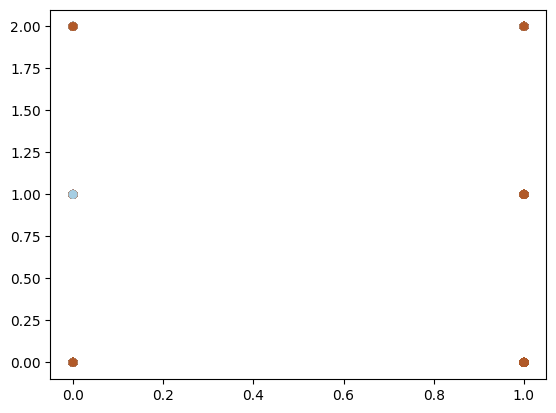

In [ ]:
svm_classifier = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("linear_svc", SVM_Linear_Scratch(C=1)),
    ]
)

svm_classifier.fit(X_train, y_train)

print(X.to_numpy().shape, y.to_numpy().shape)
# (4024, 5) (4024,)
# ValueError: X has 2 features, but StandardScaler is expecting 5 features as input.

plot_decision_support_vectors(svm_classifier, X.to_numpy(), y.to_numpy(), title='Linear SVM form scratch C=1')

In [ ]:
print(X.to_numpy().shape, y.to_numpy().shape)
plot_decision_boundary(svm_ls1, X.to_numpy(), y.to_numpy())

(4024, 5) (4024,)


ValueError: shapes (92400,2) and (5,) not aligned: 2 (dim 1) != 5 (dim 0)

In [127]:
print("===== Linear =====")
print(classification_report(y_true=y_test, y_pred=pred_ls1))
print("===== Poly degree 2 =====")
print(classification_report(y_true=y_test, y_pred=pred_nls2))
print("===== Poly degree 3 =====")
print(classification_report(y_true=y_test, y_pred=pred_nls3))
print("===== Poly degree 4 =====")
print(classification_report(y_true=y_test, y_pred=pred_nls4))
print("===== RBF gamma≈3 =====")
print(classification_report(y_true=y_test, y_pred=pred_rbf3))
print("===== RBF gamma≈4 =====")
print(classification_report(y_true=y_test, y_pred=pred_rbf4))

===== Linear =====
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.15      1.00      0.26       120

    accuracy                           0.15       805
   macro avg       0.07      0.50      0.13       805
weighted avg       0.02      0.15      0.04       805

===== Poly degree 2 =====
              precision    recall  f1-score   support

           0       0.91      0.75      0.83       685
           1       0.30      0.59      0.39       120

    accuracy                           0.73       805
   macro avg       0.60      0.67      0.61       805
weighted avg       0.82      0.73      0.76       805

===== Poly degree 3 =====
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       685
           1       0.27      0.53      0.36       120

    accuracy                           0.72       805
   macro avg       0.59      0.64      0.59       805
wei

/Users/gymmnotjim/Documents/[01]_PARA/[01]_Projects/university/intro_to_ai/intro-to-ml-and-dl-project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gymmnotjim/Documents/[01]_PARA/[01]_Projects/university/intro_to_ai/intro-to-ml-and-dl-project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/gymmnotjim/Documents/[01]_PARA/[01]_Projects/university/intro_to_ai/intro-to-ml-and-dl-project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classifica

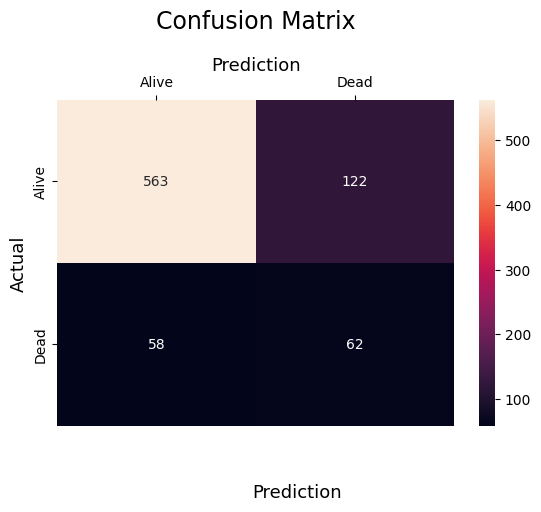

In [129]:
# Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=pred_rbf3)

sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    xticklabels=["Alive", "Dead"],
    yticklabels=["Alive", "Dead"],
)
plt.ylabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17, pad=20)
plt.gca().xaxis.set_label_position("top")
plt.xlabel("Prediction", fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, "Prediction", ha="center", fontsize=13)
plt.show()

AUC: 0.6874


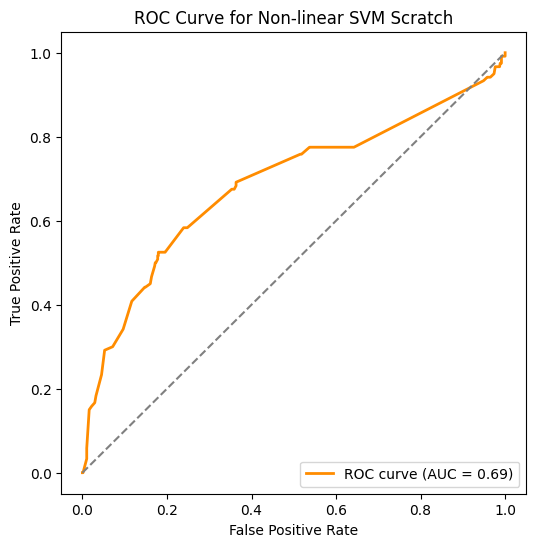

In [130]:
# ROC & AUC
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt

# Get decision scores
decision_scores = svm_rbf3.decision_function(X_test.to_numpy())  # continuous values

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), decision_scores)

# AUC
auc_score = roc_auc_score(y_test.to_numpy(), decision_scores)
print(f"AUC: {auc_score:.4f}")

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Non-linear SVM Scratch')
plt.legend(loc='lower right')
plt.show()
